# <font color='yellow'>Capstone A</font>
## <font color='yellow'>Using Hospital Bed Capacity Prediction During COVID-19 to Determine Feature Importance</font>

<b>Abstract.</b>  The Covid-19 pandemic has led to the generation of multiple types of models and feature selection methods in the field of Machine Learning. Since there has been rapid change and new regulations being introduced during the pandemic, modeling and feature selection methods have become increasingly complicated. The purpose of this study is to investigate and dive into key features to help create an understanding for the public and help show preventive measures. This study focuses on the exploration of feature selection though building multiple models, one simple linear model, one more complex model and an average of the two for prediction on impatient hospitalization rates.<br><br>

<b>Authors:</b>
* Helen Barrera, SMU MSDS Student
* Justin Ehly, SMU MSDS Student
* Blake Freeman, SMU MSDS Student
* Brad Blanchard, SMU Faculty
* Chris Papesh, UNLV Faculty

In [134]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy


In [135]:
# helper function to correctly point Justin's python to the correct platform (windows vs osX)
def justin_chdir():
    from sys import platform

    # windows: be sure so to change the <file> location
    if platform == 'win32': os.chdir(r'C:\Users\justi\github\covid_Capstone\data')

    # Mac OSX: be sure so to change the <file> location
    elif platform == 'darwin': os.chdir('/users/justinehly/github/covid_capstone/data')

justin_chdir()

In [136]:
df = pd.read_csv('OxCGRT_latest.csv', low_memory=False)

# create dataframe of only USA State level data
oxford = copy.deepcopy(df.loc[(df.RegionName.notna()) & (df.CountryCode == 'USA')]) 
oxford.reset_index(drop=True, inplace=True)
del df

In [137]:
#oxford.info()

In [138]:
# fix date column
from datetime import datetime
oxford.Date = pd.to_datetime(oxford.Date, format='%Y%m%d')

# create the state column for the data merge (this was determined at a later ddate from the initial pull and added back into the main pipeline)
oxford['state'] = oxford.RegionCode.str.slice(-2)

# put the state column first (this will help when dealing with data later)
cols = list(oxford.columns)
cols = [cols[-1]] + cols[:-1]
oxford = oxford[cols]

# drop 'CountryName', 'CountryCode', 'RegionName', 'RegionCode','Jurisdiction' because they will not be needed moving forward since we are working at the state level and only in the USA
# drop the wildcard since it is blank
# drop StringentLegacyIndexForDisplay because it is recommended to not use and is an approximation of the newer StringencyIndex. Documentation says it can be included for continuity purposes
oxford = oxford.drop(columns =['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'M1_Wildcard', 'StringencyLegacyIndexForDisplay'])

In [139]:
# get date range
print(oxford.Date.min(), oxford.Date.max())

2020-01-01 00:00:00 2021-10-16 00:00:00


In [140]:

# reduce oxford df to friday 01-24-20 thru thursday 05-27-21 to match the other data set from the USGovt website
oxford.reset_index(inplace=True, drop=True)
start_date = pd.to_datetime('20200124')
end_date = pd.to_datetime('20210527')
date_reduce_idx = np.where((oxford.Date >= start_date) & (oxford.Date <= end_date))
oxford = oxford.loc[date_reduce_idx]
oxford.reset_index(inplace=True, drop=True)
min(oxford.Date), max(oxford.Date)

(Timestamp('2020-01-24 00:00:00'), Timestamp('2021-05-27 00:00:00'))

In [141]:
print('Total weeks in the dataset: %d' % (oxford.shape[0]/7/51))

Total weeks in the dataset: 70


In [142]:
desc = pd.DataFrame(oxford.describe())
desc.T

,count,mean,std,min,25%,50%,75%,max
C1_School closing,24982.0,1.976863e+00,9.472418e-01,0.00,2.00,2.00,3.00,3.000000e+00
C1_Flag,22351.0,4.176100e-01,4.931762e-01,0.00,0.00,0.00,1.00,1.000000e+00
C2_Workplace closing,24950.0,1.397836e+00,7.826192e-01,0.00,1.00,1.00,2.00,3.000000e+00
C2_Flag,22077.0,7.759659e-01,4.169540e-01,0.00,1.00,1.00,1.00,1.000000e+00
C3_Cancel public events,24969.0,1.296568e+00,6.383088e-01,0.00,1.00,1.00,2.00,2.000000e+00
C3_Flag,22487.0,7.876996e-01,4.089455e-01,0.00,1.00,1.00,1.00,1.000000e+00
C4_Restrictions on gatherings,24990.0,2.617967e+00,1.579179e+00,0.00,2.00,3.00,4.00,4.000000e+00
C4_Flag,19050.0,7.234646e-01,4.472964e-01,0.00,0.00,1.00,1.00,1.000000e+00
C5_Close public transport,24971.0,4.719074e-01,6.151551e-01,0.00,0.00,0.00,1.00,2.000000e+00
C5_Flag,10171.0,3.179628e-01,4.657078e-01,0.00,0.00,0.00,1.00,1.000000e+00


---
### <font color='yellow'>Missing Values</font>
---
codebook https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md

- <b>Indidcators and Flags C1 - H8</b> 
    - Indicators (with the exception of E3 (USD) 0 = no new spending that day, E4 (USD) 0 = no new spending that day, H4 (USD)  0 = no new spending that day, H5 (USD) 0 = no new spending that day and M1) are oridinal and used to compute the indicies so should remain ordinal, but as integers and within the original range
    - Flags are binary and are weights for the indicators so NaN are ok to impute at 0, if there is NaN between 0-1, then it is suggested to take the average to via interpolation to not create unnecessary bias
    - Index are computed values from the Indicators and corresponding Flags based on algorithms. 
        - There are 2 versions of the index reported, 
            - Regular version that will return null there is not enough data for the calcutionn
            - ***Display version that is a smoother version and is extrapolated using the previous 7 days if there is complete data \* <font color='blue'>Suggest to use this version</font>***
            - https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/index_methodology.md

    <br><br>
- <b>Changes to be aware of:</b>
    - 27 September 2021: v3.4 note about removal of E3, E4 and H4
    - 28 June 2021: v3.3 presenting the imputed vaccine indicators (V2 summary and V3 summary) into a separate table
    - 21 June 2021: v3.02 edits to vaccine policy indicators table, fixing age ranges12 June 2021: v3.01 added section for vaccine policies
    - 5 May 2021: v2.10 added 'or all businesses open with alterations resulting in significant differences compared to non-Covid-19 operations' to C2 level 1
    - 18 March 2021: v2.9 added H8 'Protection of elderly people' indicator
    - 05 March 2021: v2.8 added 'non elderly' to definition of Clinically vulnerable groups' for H7
    - 14 January 2021: v2.7 changed 'country' to 'country/territory' and removed 'private' from C4 definition, replaced E1 flag 'formal sector workers only' to 'formal sector workers only or informal sector workers only', and 'informal workers too' to 'all workers'

In [143]:
# separate the indicators (orindal indicies) from the flags (binary weights) and the indicies for imputing
cols = list(oxford.columns)

flags = [feat for feat in cols if feat[-4:] == 'Flag'] # just get a list of the flags

indicators = [feat for feat in cols[2:34] if feat[-4:] != 'Flag'] # get a list of the idicators


index = [item for item in cols[2:] if ((item not in flags) and (item not in indicators))] # list of the indicies without the state or date that are cols[:2]

# Drop the Index rows and keep the IndexDisplay rows that are smoothed from the dataset creators
idx_to_drop = [i for i in index[2:] if (i[-7:] != 'Display')] 
display_index = [i for i in index[2:] if (i[-7:] == 'Display')] # just keep the Display Indicies

oxford = oxford.drop(columns = idx_to_drop)

# save memory
del index
del idx_to_drop


In [144]:
# impute missing Flag values
def flag_impute(flags):
    flags = flags
    for x,c in enumerate(flags): # cycle through the cols
        for i in range(len(flags[c])):  # cycle through each row
            if np.isnan(flags.iloc[i,x]):
                if (i == 0): flags.iloc[i,x] = 0  # first cell is NaN set to 0
                elif (i != (len(flags[c])-1)):
                    # prior cell = 0 (0, NaN, next_cell)
                    if (flags.iloc[i-1,x] == 0) & (np.isnan(flags.iloc[i+1, x])): flags.iloc[i,x] = 0 # (0, NaN, NaN), set to 0
                    elif (flags.iloc[i-1,x] == 0) & (flags.iloc[i+1, x] == 1): flags.iloc[i,x] = 0.5 # (0, NaN, 1), set to 0.5
                    elif (flags.iloc[i-1,x] == 0) & (flags.iloc[i+1, x] == 0): flags.iloc[i,x] = 0 # (0, NaN, 0), set to 0

                    #pior cell = 1 (1, NaN, next_cell)
                    elif (flags.iloc[i-1,x] == 1) & (np.isnan(flags.iloc[i+1, x])): flags.iloc[i,x] = 0 # (1, NaN, NaN), set to 0
                    elif (flags.iloc[i-1,x] == 1) & (flags.iloc[i+1, x] == 1): flags.iloc[i,x] = 1 # (1, NaN, 1), set to 1
                    elif (flags.iloc[i-1,x] == 1) & (flags.iloc[i+1, x] == 0): flags.iloc[i,x] = 0.5 # (1, NaN, 0), set to 0.5 (not biased)
                else: flags.iloc[i,x] = flags.iloc[i-1,x]

    return flags

indicator_flags = copy.deepcopy(oxford[flags])
oxford[flags] = flag_impute(indicator_flags)


In [145]:
# impute missing Indicator values using interpolate with limit not set, so that all NaN's in long stretches are filled in, more than likely with a zero.
# this data wll be combined to form weekly data and a mean of the index will be taken in each row and then rounded for a final result
oxford_ind = copy.deepcopy(oxford[indicators])
oxford_ind = oxford_ind.interpolate(method = 'linear', axis = 1, limit_direction = 'both')
oxford[indicators] = oxford_ind
         
            
     

In [146]:
oxford[indicators].isnull().sum()


C1_School closing                        0
C2_Workplace closing                     0
C3_Cancel public events                  0
C4_Restrictions on gatherings            0
C5_Close public transport                0
C6_Stay at home requirements             0
C7_Restrictions on internal movement     0
C8_International travel controls         0
E1_Income support                        0
E2_Debt/contract relief                  0
E3_Fiscal measures                       0
E4_International support                 0
H1_Public information campaigns          0
H2_Testing policy                        0
H3_Contact tracing                       0
H4_Emergency investment in healthcare    0
H5_Investment in vaccines                0
H6_Facial Coverings                      0
H7_Vaccination policy                    0
H8_Protection of elderly people          0
dtype: int64

In [147]:
oxford[display_index].mean()

StringencyIndexForDisplay            53.970639
GovernmentResponseIndexForDisplay    54.134277
ContainmentHealthIndexForDisplay     54.634539
EconomicSupportIndexForDisplay       50.694193
dtype: float64

### <font  color = 'yellow'> Missing Index Values</font>
- missing data appears in large chunks and based on the documentation, raw index value are very stringent on returning a null value where display values are a smoothed variation based on a 7-day rolling perdiod.
- sine the missing data for the index calculations was imputed, the NaN values can be computed using the formulas provided by the documentation.
- sub_index scores: I{j,t} = 100 * (v{j,t} - 0.5(F{j} - f{j,t})) / (N{j})  where t = time, we can ignore since we are calculating each day individually
    - Nj: max value of indicator
    - Fj: flag variable (1 = yes)
    - v{j,t}: policy value
    - f{j,t}: flag value

- index = 1/k * sum(Ij{j=i..k}) 
    - StringInd = k=9, sum(C1:C8, H1) / 9
    - GovResponse = k=16, sum(C1:C8, E1:E2, H1:H3, H6:H8)/ 16
    - ContainHealth = k=14, sum(C1:C8, H1:H3, H6:H8) / 14
    - EconSupp = k=2, sum(E1,E2) / 2


In [148]:
# formuals for each index
# create the Nj data

def ind_keys():
    ind_c = ['C'+str(i) for i in range(1,9,1)]
    ind_e = ['E1', 'E2']
    ind_h = ['H'+str(i) for i in range(1,9,1)]
    ind_h.remove('H4')
    ind_h.remove('H5')
    keys = ind_c + ind_e + ind_h
    return keys

def Nj():
    keys = ind_keys()    
    ind_ci = [3,3,2,4,2,3,2,4]
    ind_ei = [2,2]
    ind_hi = [2,3,2,4,5,3]
    values = ind_ci + ind_ei + ind_hi
    Nj = {key: value for key, value in zip(keys, values)}
    return Nj

def Fj():
    keys = ind_keys()
    values = [1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1]
    Fj = {key: value for key, value in zip(keys, values)}
    return Fj

keys = ind_keys()
Nj = {k: v for k,v in Nj().items()}
Fj = {k: v for k,v in Fj().items()}
#print(Nj)
#print(Fj)

# Build Indicators for missing Indices
missing_display = copy.deepcopy(oxford[oxford[display_index].isna().any(axis=1)]) #missing value indexes

ran = range(2,len(list(missing_display.columns))-6,2)  # create a range that covers every other number, starting with index=2 (3rd position in the list/ df)
for i, x in enumerate(ran):   
    vjt = np.array(missing_display.iloc[:,x])
    fjt = np.array(missing_display.iloc[:,x+1])
    missing_display[keys[i]] = np.where(vjt != 0, 100 * ((vjt - 0.5*(Fj[keys[i]] - fjt)) / Nj[keys[i]]), 0)
    #print(i,x,missing_display[keys[i]])

#print(missing_display.iloc[:,-16:])

# Impute Missing Indices
# build a dictionary of k's and df cols
values = {
    'col': display_index,
    'k': [9, 16, 14, 2], 
    'idx': [np.r_[40:48,50], np.r_[40:56], np.r_[40:48,50:56], np.r_[48,49]]}

#index_vars = {key: value for key, value in zip(display_index,values)}

for i in range(4):
    condition = missing_display[values['col'][i]].isna() # only replace values that are NaN
    k = values['k'][i]  # k value for the index
    indicator_sum = missing_display.iloc[:,values['idx'][i]].sum(axis=1)  # sum of the indicators for the index value
    missing_display[values['col'][i]] = np.where(condition, indicator_sum / k, condition)



In [149]:
missing_display[display_index].isna().sum()

StringencyIndexForDisplay            0
GovernmentResponseIndexForDisplay    0
ContainmentHealthIndexForDisplay     0
EconomicSupportIndexForDisplay       0
dtype: int64

In [150]:
mdx = missing_display.index
oxford.iloc[mdx,np.r_[36:40]] = missing_display[display_index] # assign the columns back that no longer have NaN


In [151]:
oxford.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24990 entries, 0 to 24989
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   state                                  24990 non-null  object        
 1   Date                                   24990 non-null  datetime64[ns]
 2   C1_School closing                      24990 non-null  float64       
 3   C1_Flag                                24990 non-null  float64       
 4   C2_Workplace closing                   24990 non-null  float64       
 5   C2_Flag                                24990 non-null  float64       
 6   C3_Cancel public events                24990 non-null  float64       
 7   C3_Flag                                24990 non-null  float64       
 8   C4_Restrictions on gatherings          24990 non-null  float64       
 9   C4_Flag                                24990 non-null  float6

---
### <font color='green'>***Done Imputing***</font>
---

In [152]:
# combine the weeks in the oxford df
import datetime
min(oxford.Date) + datetime.timedelta(6)
#oxford.groupby(by='Date').sum()[['ConfirmedCases']]
# look up pd.Grouper
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas/45281418
# create weekly combinations by state
# reference on the frequency: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
weekly_oxford = copy.deepcopy(oxford)
weekly_oxford = weekly_oxford.groupby(['state', pd.Grouper(key = 'Date', freq='W-FRI')]).mean()

weekly_oxford.reset_index(inplace=True, drop=False)


In [153]:
np.min(oxford.Date), np.max(oxford.Date)

(Timestamp('2020-01-24 00:00:00'), Timestamp('2021-05-27 00:00:00'))

In [154]:
weekly_oxford

,state,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,...,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,ConfirmedCases,ConfirmedDeaths,StringencyIndexForDisplay,GovernmentResponseIndexForDisplay,ContainmentHealthIndexForDisplay,EconomicSupportIndexForDisplay
0,AK,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,5.560000,8.330000,9.520000,0.000000
1,AK,2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,5.560000,8.777143,9.520000,3.571429
2,AK,2020-02-07,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,6.352857,8.777143,10.031429,0.000000
3,AK,2020-02-14,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,11.110000,11.460000,13.100000,0.000000
4,AK,2020-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,11.110000,11.460000,13.100000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,WY,2021-04-30,1.0,1.0,0.0,0.0,1.0,1.0,2.000000,1.000000,...,5.0,1.0,1.0,1.0,57900.428571,706.142857,48.150000,51.820000,53.870000,37.500000
3617,WY,2021-05-07,1.0,1.0,0.0,0.0,1.0,1.0,2.000000,1.000000,...,5.0,1.0,1.0,1.0,58361.285714,708.714286,48.150000,51.931429,53.997143,37.500000
3618,WY,2021-05-14,1.0,1.0,0.0,0.0,1.0,1.0,2.000000,1.000000,...,5.0,1.0,1.0,1.0,58830.428571,711.142857,48.150000,52.600000,54.760000,37.500000
3619,WY,2021-05-21,1.0,1.0,0.0,0.0,1.0,1.0,1.714286,0.857143,...,5.0,1.0,1.0,1.0,59332.571429,712.571429,47.355714,52.154286,54.250000,37.500000


In [155]:
weekly_oxford.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621 entries, 0 to 3620
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   state                                  3621 non-null   object        
 1   Date                                   3621 non-null   datetime64[ns]
 2   C1_School closing                      3621 non-null   float64       
 3   C1_Flag                                3621 non-null   float64       
 4   C2_Workplace closing                   3621 non-null   float64       
 5   C2_Flag                                3621 non-null   float64       
 6   C3_Cancel public events                3621 non-null   float64       
 7   C3_Flag                                3621 non-null   float64       
 8   C4_Restrictions on gatherings          3621 non-null   float64       
 9   C4_Flag                                3621 non-null   float64 

--- 
### <font color='yellow'> Import 2nd Dataset  </font>
- COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv
- https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u
#### Notes About the Data
- Facility level data, aggregated on weekly basis F-Th.
- Main sources: (1) HHS TeleTracking and (2) directly to HHS Protect by state/ territorial health depts for their healthcare facilities
- Hosp Pop includs all hospitals registered with Centers for Medicare & Medicaid Services (CMS) as of 6-1-20. Includes non-CMS hospitals reporting since 7-15-20.
- It does not include psychiatric, rehabilitation, Indian Health Service (IHS) facilities, U.S. Department of Veterans Affairs (VA) facilities, Defense Health Agency (DHA) facilities, and religious non-medical facilities.
- No statistical information is provided for imputing missing values
- Suppression is applied to the file for sums and averages less than four (4). In these cases, the field will be replaced with “-999,999”
- For influenza fields listed in the file, the current HHS guidance marks these fields as optional. As a result, coverage of these elements are varied.
- Elements Reported
    - _coverage: how many times a facility reported that elements during collection week
    - _sum: sum of reports a facility provided that week
    - _avg: average of reports provided for a facility for that element during that collection week 
- On May 3, 2021, the following fields have been added to this data set.
    - hhs_ids
    - previous_day_admission_adult_covid_confirmed_7_day_coverage
    - previous_day_admission_pediatric_covid_confirmed_7_day_coverage
    - previous_day_admission_adult_covid_suspected_7_day_coverage
    - previous_day_admission_pediatric_covid_suspected_7_day_coverage
    - previous_week_personnel_covid_vaccinated_doses_administered_7_day_sum
    - total_personnel_covid_vaccinated_doses_none_7_day_sum
    - total_personnel_covid_vaccinated_doses_one_7_day_sum
    - total_personnel_covid_vaccinated_doses_all_7_day_sum
    - previous_week_patients_covid_vaccinated_doses_one_7_day_sum
    - previous_week_patients_covid_vaccinated_doses_all_7_day_sum

In [156]:
healthdata = pd.read_csv('COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv', low_memory=False)
# reduce to match the dates in the oxford dataframe
healthdata.collection_week = pd.to_datetime(healthdata.collection_week, format = '%Y/%m/%d')
healthdata.drop(columns = ['hospital_pk', 'ccn', 'hospital_name', 'address', 'city', 'zip', 'hospital_subtype', 'fips_code', 
                            'is_metro_micro', 'geocoded_hospital_address', 'hhs_ids'], inplace = True)

# remove territories outisde of USA (except DC) to match oxford dataset
healthdata = healthdata[~healthdata.state.isin(['GU','MP','PR','VI'])]
healthdata.reset_index(inplace = True, drop = True)

# reduce to the dates set in the oxford dataframe
start_date = pd.to_datetime('20200124')
end_date = pd.to_datetime('20210528')
date_reduce_idx = np.where((healthdata.collection_week >= start_date) & (healthdata.collection_week <= end_date))
healthdata = healthdata.loc[date_reduce_idx]

print('Shape:', healthdata.shape)
healthdata

Shape: (295525, 95)


,collection_week,state,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
0,2020-06-26,CA,122.0,NaN,NaN,117.1,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2020-05-29,CA,141.0,NaN,NaN,25.6,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2020-04-17,DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2020-06-19,FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2020-04-03,FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374173,2020-12-11,WI,31.0,31.0,31.0,8.8,8.8,5.0,4.0,0.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
374174,2020-11-06,SD,65.0,65.0,53.0,41.3,41.1,-999999.0,-999999.0,0.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
374175,2021-01-01,WI,139.1,130.1,107.1,102.7,93.4,11.1,11.0,0.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
374177,2021-01-08,TX,168.9,162.3,130.9,104.9,102.6,39.1,35.3,0.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False


In [157]:
np.min(healthdata.collection_week), np.max(healthdata.collection_week)  

(Timestamp('2020-01-24 00:00:00'), Timestamp('2021-05-28 00:00:00'))

In [158]:
healthdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295525 entries, 0 to 374178
Data columns (total 95 columns):
 #   Column                                                                              Non-Null Count   Dtype         
---  ------                                                                              --------------   -----         
 0   collection_week                                                                     295525 non-null  datetime64[ns]
 1   state                                                                               295525 non-null  object        
 2   total_beds_7_day_avg                                                                276868 non-null  float64       
 3   all_adult_hospital_beds_7_day_avg                                                   218937 non-null  float64       
 4   all_adult_hospital_inpatient_beds_7_day_avg                                         219744 non-null  float64       
 5   inpatient_beds_used_7_day_avg        

In [159]:
# prior to imputing, replace all -999,999 with 0 because that represents a result < 4
healthdata.replace([-999999.0], [0], inplace = True) 

healthdata[healthdata.total_beds_7_day_avg == 0]

,collection_week,state,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
64,2020-06-26,NY,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
80,2020-05-08,PA,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
83,2020-05-08,PA,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
100,2020-05-08,PA,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
147,2020-05-29,TX,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373914,2020-07-03,TX,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
373919,2020-07-03,VA,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
373935,2020-07-03,VA,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
374021,2020-07-17,WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,4,4,NaN,NaN,NaN,NaN,NaN,NaN,False


In [160]:


health_impute = copy.deepcopy(healthdata.iloc[:,2:-1])
health_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295525 entries, 0 to 374178
Data columns (total 92 columns):
 #   Column                                                                              Non-Null Count   Dtype  
---  ------                                                                              --------------   -----  
 0   total_beds_7_day_avg                                                                276868 non-null  float64
 1   all_adult_hospital_beds_7_day_avg                                                   218937 non-null  float64
 2   all_adult_hospital_inpatient_beds_7_day_avg                                         219744 non-null  float64
 3   inpatient_beds_used_7_day_avg                                                       276868 non-null  float64
 4   all_adult_hospital_inpatient_bed_occupied_7_day_avg                                 222853 non-null  float64
 5   total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg           22

In [161]:
# With no statistical data to impute from, it makes the most sense to utilize the interpolate again and then combine the data into state/ weekly data to match the oxford dataframe
health_impute = copy.deepcopy(healthdata.iloc[:,2:-1])  # create a copy of the numeric columns
health_impute = health_impute.interpolate(method = 'linear', axis = 1, limit_direction = 'both')
health_impute

,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,...,previous_day_admission_adult_covid_confirmed_7_day_coverage,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
0,122.0,120.366667,118.733333,117.1,117.916667,118.733333,119.55,120.366667,121.183333,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,141.0,102.533333,64.066667,25.6,42.566667,59.533333,76.50,93.466667,110.433333,127.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91.0,91.000000,91.000000,91.0,91.000000,91.000000,91.00,91.000000,91.000000,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,522.9,522.900000,522.900000,522.9,522.900000,522.900000,522.90,522.900000,522.900000,522.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,24.000000,24.000000,24.0,24.000000,24.000000,24.00,24.000000,24.000000,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374173,31.0,31.000000,31.000000,8.8,8.800000,5.000000,4.00,0.000000,0.000000,31.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
374174,65.0,65.000000,53.000000,41.3,41.100000,0.000000,0.00,0.000000,0.000000,53.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
374175,139.1,130.100000,107.100000,102.7,93.400000,11.100000,11.00,0.000000,0.000000,116.1,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
374177,168.9,162.300000,130.900000,104.9,102.600000,39.100000,35.30,0.000000,0.000000,142.7,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


In [162]:
# return the imputed data to the original dataframe
healthdata.iloc[:,2:-1] = health_impute

del health_impute # free up memory

healthdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295525 entries, 0 to 374178
Data columns (total 95 columns):
 #   Column                                                                              Non-Null Count   Dtype         
---  ------                                                                              --------------   -----         
 0   collection_week                                                                     295525 non-null  datetime64[ns]
 1   state                                                                               295525 non-null  object        
 2   total_beds_7_day_avg                                                                295525 non-null  float64       
 3   all_adult_hospital_beds_7_day_avg                                                   295525 non-null  float64       
 4   all_adult_hospital_inpatient_beds_7_day_avg                                         295525 non-null  float64       
 5   inpatient_beds_used_7_day_avg        

In [163]:
# Group the healthdata by state/ date
weekly_healthdata = copy.deepcopy(healthdata)
weekly_healthdata = weekly_healthdata.groupby(['state', 'collection_week']).sum() # sum since the data is collecte by location and deduped prior to publishing
weekly_healthdata.reset_index(inplace = True, drop = False)
weekly_healthdata

,state,collection_week,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
0,AK,2020-03-20,81.0,60.000000,39.000000,18.0,24.333333,30.666667,37.00,43.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,AK,2020-03-27,1353.0,1067.500000,782.000000,496.5,595.916667,695.333333,794.75,894.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,AK,2020-04-03,1405.0,1111.033333,817.066667,523.1,618.033333,712.966667,807.90,902.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,AK,2020-04-10,1457.4,1124.500000,791.600000,458.7,577.650000,696.600000,815.55,934.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,AK,2020-04-17,1374.7,1022.000000,669.300000,316.6,467.716667,618.833333,769.95,921.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,WY,2021-04-30,1516.0,1341.000000,1217.000000,566.9,547.800000,15.200000,15.20,0.000000,...,177.0,177.0,177.0,165.0,3938.0,3555.0,3878.0,1507.0,1306.0,1
3358,WY,2021-05-07,1267.0,1171.000000,997.000000,412.9,385.100000,7.900000,7.90,0.000000,...,167.0,167.0,167.0,145.0,4153.0,4274.0,4588.0,986.0,1054.0,1
3359,WY,2021-05-14,1267.0,1171.000000,997.000000,423.4,393.100000,17.400000,17.30,0.000000,...,169.0,169.0,169.0,167.0,3990.0,4160.0,4450.0,943.0,1091.0,0
3360,WY,2021-05-21,1267.0,1157.000000,997.000000,404.2,383.300000,22.400000,22.30,0.000000,...,169.0,169.0,169.0,161.0,4158.0,4380.0,4678.0,1059.0,1058.0,0


In [164]:
weekly_healthdata.isna().sum().sum()

0

In [165]:
min_start_week_by_state = weekly_healthdata.groupby('state').agg({'collection_week': np.min})  #find the start date for each state's collection of hospital information
best_start_date = min_start_week_by_state.max() # get the latest start date that includes all states
print('Best Start Date: ', best_start_date) # best date to start the data set


# match the start dates for the datasets
weekly_healthdata = weekly_healthdata[weekly_healthdata.collection_week >= best_start_date[0]]
weekly_oxford = weekly_oxford[weekly_oxford.Date >= best_start_date[0]]

print(weekly_healthdata.shape, weekly_oxford.shape)

Best Start Date:  collection_week   2020-03-27
dtype: datetime64[ns]
(3162, 95) (3162, 40)


---
### <font color='yellow'>End of Dataset 2 Impute</font>
---
### <font color='yellow'>Start Dataset Merge</font>


In [166]:
covid = weekly_oxford.merge(weekly_healthdata, how = 'left', left_on = ('state','Date'), right_on = ('state','collection_week'))
covid.drop(columns = ['collection_week'], inplace = True)

In [167]:
print(covid.shape)
print(covid.isna().sum().sum())

(3162, 133)
0


In [168]:
covid

,state,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,...,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
0,AK,2020-03-27,3.0,1.0,2.857143,0.0,2.0,1.0,4.000000,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,AK,2020-04-03,3.0,1.0,3.000000,1.0,2.0,1.0,4.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,AK,2020-04-10,3.0,1.0,3.000000,1.0,2.0,1.0,4.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,AK,2020-04-17,3.0,1.0,3.000000,1.0,2.0,1.0,4.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,AK,2020-04-24,3.0,1.0,2.857143,1.0,2.0,1.0,3.857143,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,WY,2021-04-30,1.0,1.0,0.000000,0.0,1.0,1.0,2.000000,1.000000,...,177.0,177.0,177.0,165.0,3938.0,3555.0,3878.0,1507.0,1306.0,1
3158,WY,2021-05-07,1.0,1.0,0.000000,0.0,1.0,1.0,2.000000,1.000000,...,167.0,167.0,167.0,145.0,4153.0,4274.0,4588.0,986.0,1054.0,1
3159,WY,2021-05-14,1.0,1.0,0.000000,0.0,1.0,1.0,2.000000,1.000000,...,169.0,169.0,169.0,167.0,3990.0,4160.0,4450.0,943.0,1091.0,0
3160,WY,2021-05-21,1.0,1.0,0.000000,0.0,1.0,1.0,1.714286,0.857143,...,169.0,169.0,169.0,161.0,4158.0,4380.0,4678.0,1059.0,1058.0,0


---
## EDA
---

In [169]:
# helper function: look at correlation heatmap

def corr_map(data):
    corr = data.corr()
    matrix = np.triu(corr)


    f, ax = plt.subplots(figsize=(20,20))
    heatmap = sns.heatmap(corr, annot=False, mask=matrix, cmap='BrBG')
    heatmap.set_title('Correlation Columns', fontdict={'fontsize':18}, pad=16);
    plt.show()

########################################################################

# automating the process of removing highly correlated variables
# returns a list of features that are correlated above the percentage fed into the function

def auto_corr(data, corr_percentage):
    corr_matrix = data.corr().abs() #get the correlation matrix with absolute values

    # select just the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) 
    #print(upper_tri) # view the columns

    # get columns with over 0.95 (95%) correlation

    #use list comprehension to get a list of ultra high correlated variables
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_percentage)] 

    # print list of variables to drop from dataframe
    print('\n These are the variables that are correlated over %s:' % corr_percentage,to_drop)
    corrs = len(to_drop)
    print('\nThere are a total of %d variables to drop due to a correlation over %s' % (corrs, corr_percentage))
    return to_drop


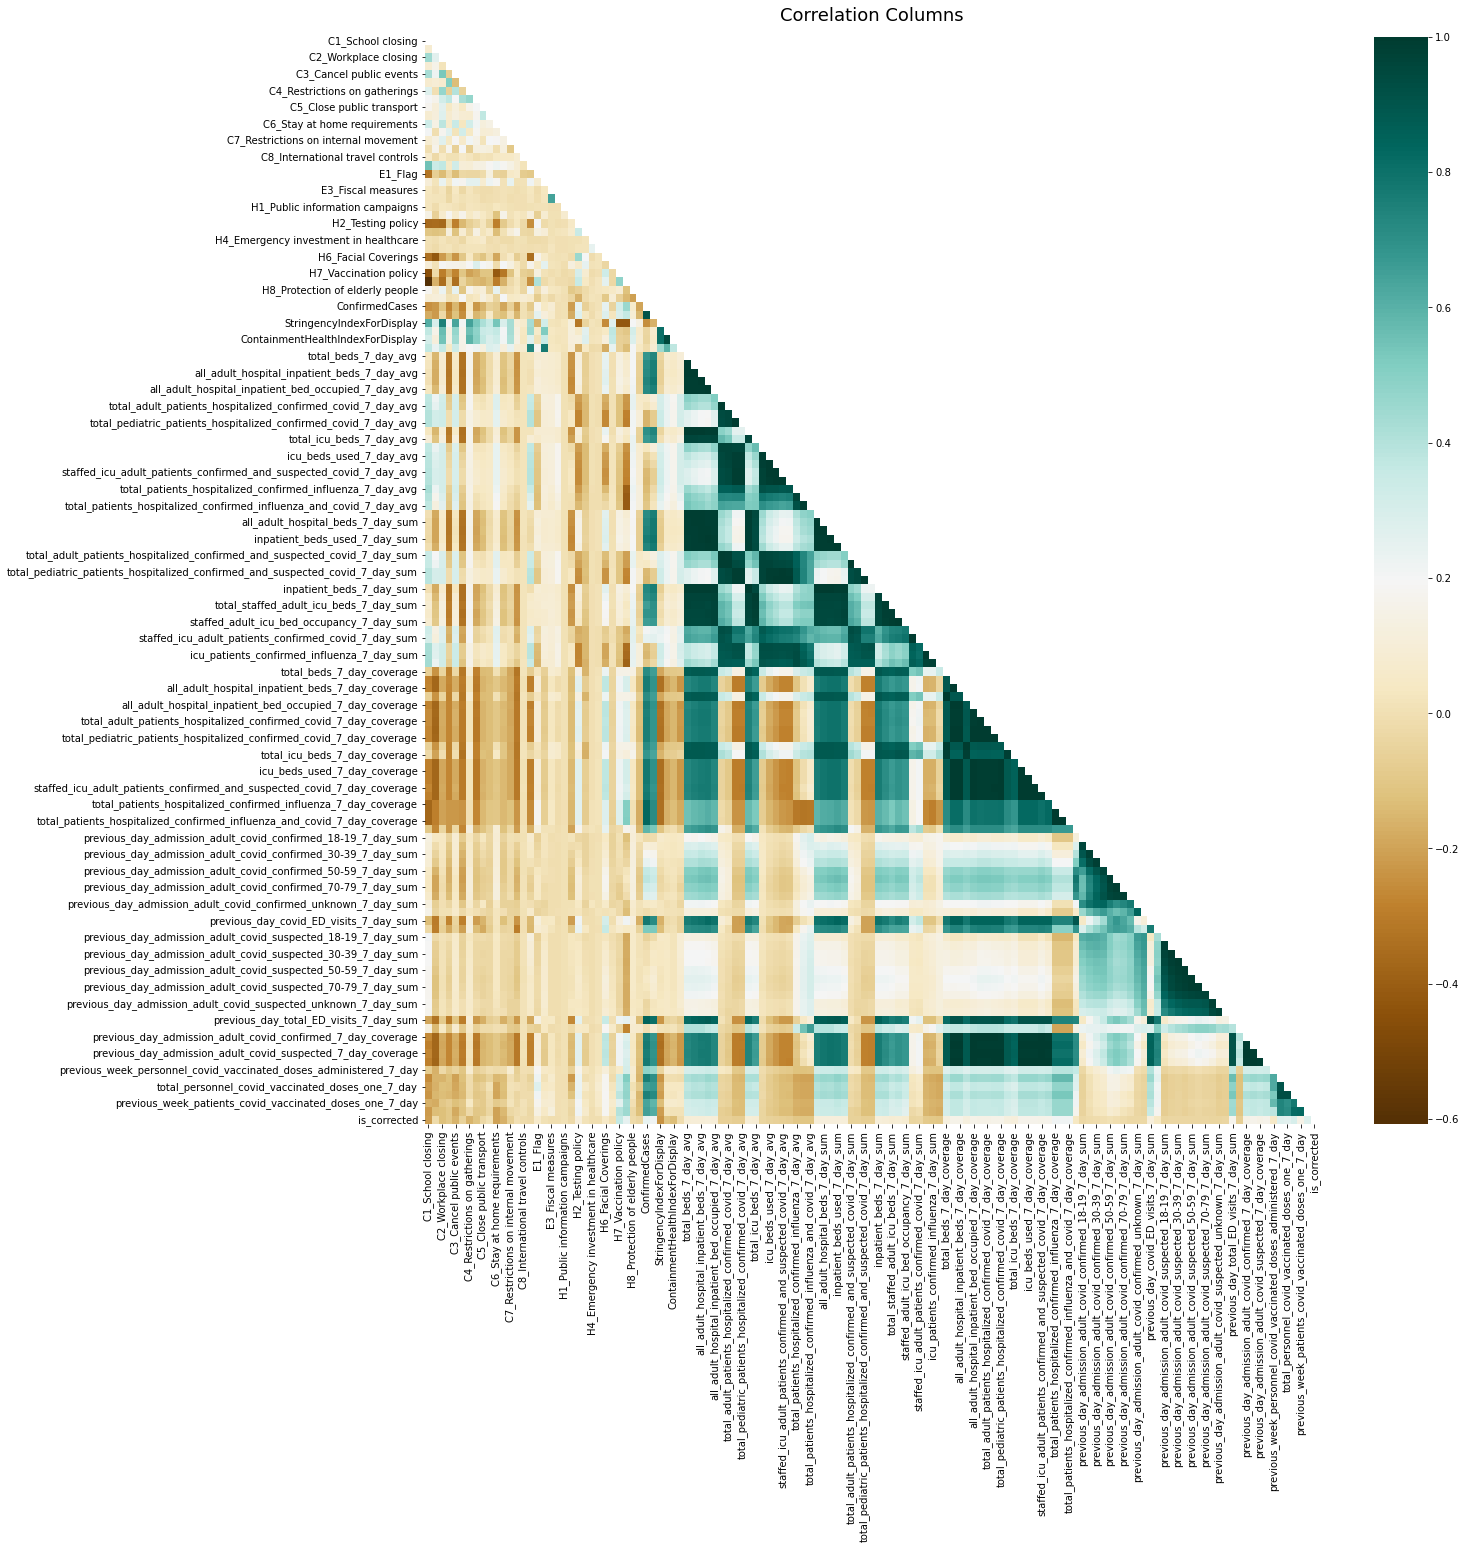

In [170]:
# Call correlation heatmap function

corr_map(covid)

In [171]:
# call auto correlation fucnction

correlated_features = auto_corr(covid, 0.95)



 These are the variables that are correlated over 0.95: ['ContainmentHealthIndexForDisplay', 'all_adult_hospital_beds_7_day_avg', 'all_adult_hospital_inpatient_beds_7_day_avg', 'inpatient_beds_used_7_day_avg', 'all_adult_hospital_inpatient_bed_occupied_7_day_avg', 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg', 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg', 'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg', 'inpatient_beds_7_day_avg', 'total_icu_beds_7_day_avg', 'total_staffed_adult_icu_beds_7_day_avg', 'icu_beds_used_7_day_avg', 'staffed_adult_icu_bed_occupancy_7_day_avg', 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg', 'staffed_icu_adult_patients_confirmed_covid_7_day_avg', 'icu_patients_confirmed_influenza_7_day_avg', 'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg', 'total_beds_7_day_sum', 'all_adult_hospital_beds_7_day_sum', 'all_adult_hospital_inpatient_beds_7_day_sum', 'i

In [172]:
covid = covid.drop(columns = correlated_features)
covid

,state,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,...,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
0,AK,2020-03-27,3.0,1.0,2.857143,0.0,2.0,1.0,4.000000,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,AK,2020-04-03,3.0,1.0,3.000000,1.0,2.0,1.0,4.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,AK,2020-04-10,3.0,1.0,3.000000,1.0,2.0,1.0,4.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,AK,2020-04-17,3.0,1.0,3.000000,1.0,2.0,1.0,4.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,AK,2020-04-24,3.0,1.0,2.857143,1.0,2.0,1.0,3.857143,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,WY,2021-04-30,1.0,1.0,0.000000,0.0,1.0,1.0,2.000000,1.000000,...,0.0,3622.0,0.0,165.0,3938.0,3555.0,3878.0,1507.0,1306.0,1
3158,WY,2021-05-07,1.0,1.0,0.000000,0.0,1.0,1.0,2.000000,1.000000,...,0.0,3157.0,0.0,145.0,4153.0,4274.0,4588.0,986.0,1054.0,1
3159,WY,2021-05-14,1.0,1.0,0.000000,0.0,1.0,1.0,2.000000,1.000000,...,0.0,3400.0,0.0,167.0,3990.0,4160.0,4450.0,943.0,1091.0,0
3160,WY,2021-05-21,1.0,1.0,0.000000,0.0,1.0,1.0,1.714286,0.857143,...,0.0,3453.0,0.0,161.0,4158.0,4380.0,4678.0,1059.0,1058.0,0


In [173]:
list(covid.columns)


['state',
 'Date',
 'C1_School closing',
 'C1_Flag',
 'C2_Workplace closing',
 'C2_Flag',
 'C3_Cancel public events',
 'C3_Flag',
 'C4_Restrictions on gatherings',
 'C4_Flag',
 'C5_Close public transport',
 'C5_Flag',
 'C6_Stay at home requirements',
 'C6_Flag',
 'C7_Restrictions on internal movement',
 'C7_Flag',
 'C8_International travel controls',
 'E1_Income support',
 'E1_Flag',
 'E2_Debt/contract relief',
 'E3_Fiscal measures',
 'E4_International support',
 'H1_Public information campaigns',
 'H1_Flag',
 'H2_Testing policy',
 'H3_Contact tracing',
 'H4_Emergency investment in healthcare',
 'H5_Investment in vaccines',
 'H6_Facial Coverings',
 'H6_Flag',
 'H7_Vaccination policy',
 'H7_Flag',
 'H8_Protection of elderly people',
 'H8_Flag',
 'ConfirmedCases',
 'ConfirmedDeaths',
 'StringencyIndexForDisplay',
 'GovernmentResponseIndexForDisplay',
 'EconomicSupportIndexForDisplay',
 'total_beds_7_day_avg',
 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
 

---
### Graph to compare Cases and Deaths over time
--

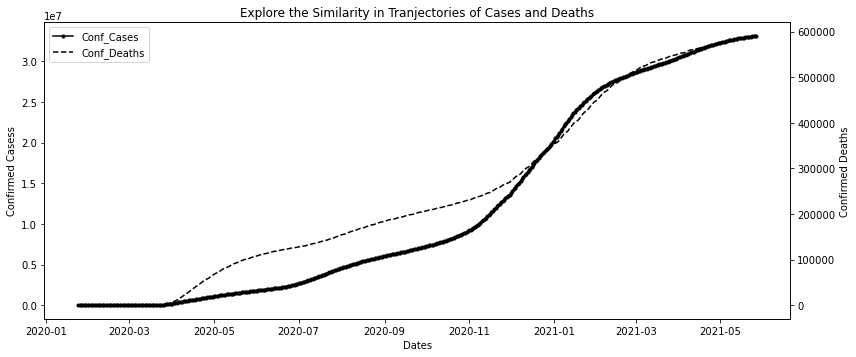

In [200]:
# get an idea of how the cases and deaths align over time when scaled
fig, ax1 = plt.subplots(figsize=(12,5))

# plot conf_cases
ax1.set_xlabel('Dates')
ax1.set_ylabel('Confirmed Casess')
ax1.plot(oxford.groupby(by='Date').sum()['ConfirmedCases'], '.-', color = 'black', label = 'Conf_Cases')
ax1.tick_params(axis='y', labelcolor = 'black')

# add additional axes to same plot
ax2 = ax1.twinx()

# plot conf_deaths
ax2.set_ylabel('Confirmed Deaths')
ax2.plot(oxford.groupby(by='Date').sum()['ConfirmedDeaths'], '--', color = 'black', label = 'Conf_Deaths')
ax2.tick_params(axis='y', labelcolor='black')

# prevent any offsets
fig.tight_layout()

# get plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')
ax2.set_title('Explore the Similarity in Tranjectories of Cases and Deaths')
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

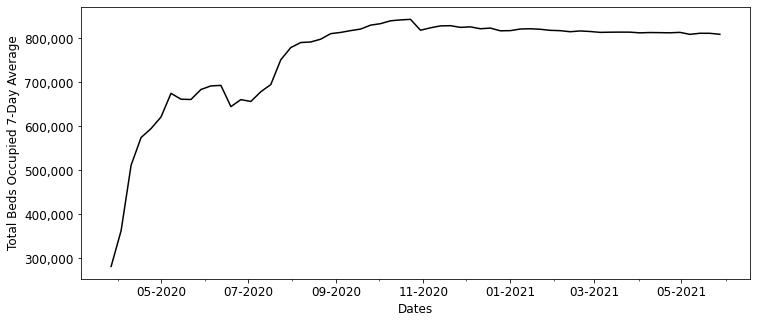

In [208]:
# get an idea of how the cases and deaths align over time when scaled
import matplotlib as mpl
import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(12,5))

# ticks every 2 months
ticks_two_mons = dates.MonthLocator(interval = 2)
ax.xaxis.set_major_locator(ticks_two_mons)

# minor ticks in between dates
ax.xaxis.set_minor_locator(dates.MonthLocator())

# format date display
ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))


# plot 7-day average bed occupancy
ax.set_xlabel('Dates')
ax.set_ylabel('Total Beds Occupied 7-Day Average')
ax.plot(covid.groupby(by='Date').sum()['total_beds_7_day_avg'], color = 'black')
ax.tick_params(axis='y', color = 'black')
#ax.set_title('Total Beds 7-Day Average by Date in the USA 01-01-24 thru 05-28-21')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
mpl.rcParams.update({'font.size': 14})
plt.show()